In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, gc, random
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import losses, models, optimizers
import tensorflow_addons as tfa
from tf_nn_utils import *
from viterbi_utils import *
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

import numpy.fft as fft
from scipy import signal as scisig
from viterbi_utils import *
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)

# set gpu memory growth
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(1993)

In [2]:
df_train = pd.read_pickle('../features/train_clean.pkl')
df_test = pd.read_pickle('../features/test_clean.pkl')
TARGET = "open_channels"
df_test[TARGET] = 0

df_train["group"] = df_train["batch"].astype("str") + "_" + df_train["mini_batch"].astype("str")
df_test["group"] = df_test["batch"].astype("str") + "_" + df_test["mini_batch"].astype("str")

df_train["signal_original"] = df_train["signal"].copy()
df_test["signal_original"] = df_test["signal"].copy()

print(f"train size:{df_train.shape}, test size:{df_test.shape}")
df_train.head()

train size:(4500000, 8), test size:(2000000, 9)


,time,signal,open_channels,local_time,batch,mini_batch,group,signal_original
0,0.0001,-2.7600,0,0.0001,1,1,1_1,-2.7600
1,0.0002,-2.8557,0,0.0002,1,1,1_1,-2.8557
2,0.0003,-2.4074,0,0.0003,1,1,1_1,-2.4074
3,0.0004,-3.1404,0,0.0004,1,1,1_1,-3.1404
4,0.0005,-3.1525,0,0.0005,1,1,1_1,-3.1525


In [3]:
# configurations and main hyperparammeters
nn_epochs = 100
nn_batch_size = 16
class_num = 6
LR = 0.001

In [4]:
# mini model
BATCH_GROUP = [6, 9]
df_train = df_train[df_train.batch.isin(BATCH_GROUP)].reset_index(drop=True)
TEST_GROUP = ["1_3", "2_2"]
df_test = df_test[df_test.group.isin(TEST_GROUP)].reset_index(drop=True)

print(f"train size:{df_train.shape}, test size:{df_test.shape}")

train size:(1000000, 8), test size:(200000, 9)


In [5]:
sig_mean = get_mean(df_train)
print(np.array(sig_mean).round(3))

[-2.743 -1.507 -0.274  0.96   2.197  3.433]


In [6]:
# remove the 50 hz noise using bandstop filter (group)
for group_i in df_train.group.unique():

    batch_i = df_train[df_train.group.isin([group_i])]
    signal_recovered = rm_noise(batch_i, sig_mean=sig_mean)
    df_train.loc[df_train.group.isin([group_i]), "signal"] = signal_recovered

In [7]:
sig_mean = get_mean(df_train)
print(np.array(sig_mean).round(3))

[-2.742 -1.505 -0.273  0.961  2.197  3.433]


In [8]:
# feature engineering here
def fe(df, is_train):

    # shift features
    for shift_val in range(1, 4):
        group_on = "group"
        df[f'shift+{shift_val}'] = df.groupby([group_on])['signal'].shift(shift_val).fillna(0)
        df[f'shift_{shift_val}'] = df.groupby([group_on])['signal'].shift(-shift_val).fillna(0)
    
    return df

# df_train = fe(df_train, is_train=1)
# df_test = fe(df_test, is_train=0)

use_cols = [
    col for col in df_train.columns if col not in
    ["time", "local_time", "open_channels", "batch", "mini_batch", "group", "oof", "signal_original"]
]
print("Used columns is", use_cols)

Used columns is ['signal']


In [9]:
viterbi_cols = ["viterbi_" + str(i) for i in range(df_train[TARGET].nunique())]
use_cols = use_cols + viterbi_cols
ghmm = {}

for col in viterbi_cols:
    df_train[col] = 0
    df_test[col] = 0

init_prob = [0, 0, 0, 0, 0, 1]

hmm_kf = GroupKFold(n_splits=10)
hmm_groups = df_train.group.values
df_train["oof"] = 0
df_test["oof"] = 0
for index, (tr_idx, val_idx) in enumerate(hmm_kf.split(df_train, df_train[TARGET], hmm_groups)):
    train_x, train_y = df_train.loc[tr_idx]["signal"].values, df_train.loc[tr_idx][TARGET].values
    valid_x, valid_y = df_train.loc[val_idx]["signal"].values, df_train.loc[val_idx][TARGET].values
    print("Running folder", index + 1, ": Evaluate on", np.unique(hmm_groups[val_idx]))
    ghmm[index] = GaussHMM(init_prob)
    ghmm[index].fit(train_x, train_y)
    df_train.loc[val_idx, "oof"] = ghmm[index].predict(valid_x)
    df_train.loc[val_idx, viterbi_cols] = ghmm[index].predict_proba(valid_x)
    print(index+1, ": F1 macro =", f1_score(y_pred=df_train.loc[val_idx, "oof"], y_true=valid_y, average='macro').round(6))
    
    # test
    for col in TEST_GROUP:
        df_test.loc[df_test.group == col, "oof"] += ghmm[index].predict(df_test.loc[df_test.group == col, "signal"].values) / hmm_kf.n_splits
        df_test.loc[df_test.group == col, viterbi_cols] += ghmm[index].predict_proba(df_test.loc[df_test.group == col, "signal"].values) / hmm_kf.n_splits

df_test["oof"] = df_test["oof"].round().astype(int)
print("==> OOF F1 macro =", f1_score(y_pred=df_train["oof"].values, y_true=df_train[TARGET].values, average='macro').round(4))

Running folder 1 : Evaluate on ['9_5']
1 : F1 macro = 0.972666
Running folder 2 : Evaluate on ['9_4']
2 : F1 macro = 0.97272
Running folder 3 : Evaluate on ['9_3']
3 : F1 macro = 0.970415
Running folder 4 : Evaluate on ['9_2']
4 : F1 macro = 0.972922
Running folder 5 : Evaluate on ['9_1']
5 : F1 macro = 0.97482
Running folder 6 : Evaluate on ['6_5']
6 : F1 macro = 0.972345
Running folder 7 : Evaluate on ['6_4']
7 : F1 macro = 0.969041
Running folder 8 : Evaluate on ['6_3']
8 : F1 macro = 0.974097
Running folder 9 : Evaluate on ['6_2']
9 : F1 macro = 0.971718
Running folder 10 : Evaluate on ['6_1']
10 : F1 macro = 0.97247
==> OOF F1 macro = 0.9725


In [10]:
# pseudo labeling to remove 50hz noise in test
for i in tqdm(range(20)):
    # remove test signal noise here using oof
    for group_i in TEST_GROUP:
        batch_test_i = df_test[df_test.group.isin([group_i])].copy()
        signal_test_recovered = rm_noise(batch_test_i, col="oof", sig_mean=sig_mean)
        df_test.loc[df_test.group.isin([group_i]), "signal"] = signal_test_recovered
    
    df_test["oof"] = 0
    df_test[viterbi_cols] = 0
    # re-predict test
    for index in range(len(ghmm)):
        for col in TEST_GROUP:
            df_test.loc[df_test.group == col, "oof"] += ghmm[index].predict(df_test.loc[df_test.group == col, "signal"].values) / hmm_kf.n_splits
            df_test.loc[df_test.group == col, viterbi_cols] += ghmm[index].predict_proba(df_test.loc[df_test.group == col, "signal"].values) / hmm_kf.n_splits
    df_test["oof"] = df_test["oof"].round().astype(int)

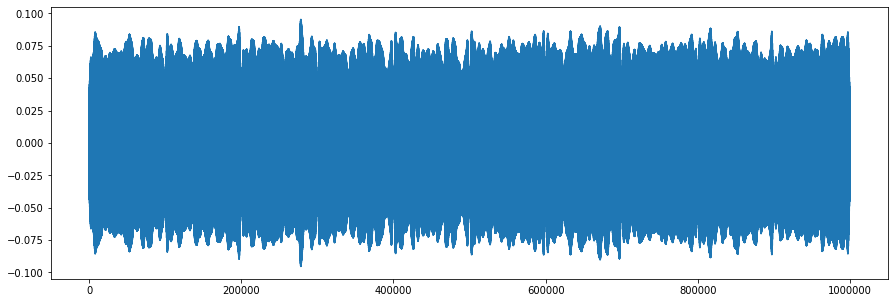

In [11]:
fig = plt.figure(figsize=(15,5))
plt.plot((df_train["signal_original"] - df_train["signal"]).values)

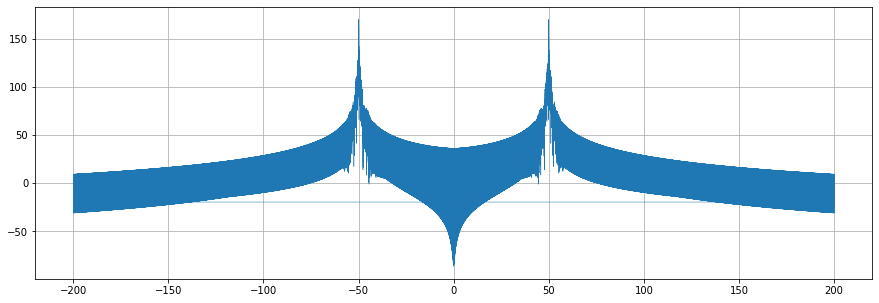

In [12]:
fig = plt.figure(figsize=(15,5))

fs=10000
fft = np.fft.fft((df_train["signal_original"] - df_train["signal"]).values)
psd = np.abs(fft) ** 2
fftfreq = np.fft.fftfreq(len(psd),1/fs)

i = abs(fftfreq) < 200
plt.grid()
plt.plot(fftfreq[i], 20*np.log10(psd[i]), linewidth=.5)

plt.show()

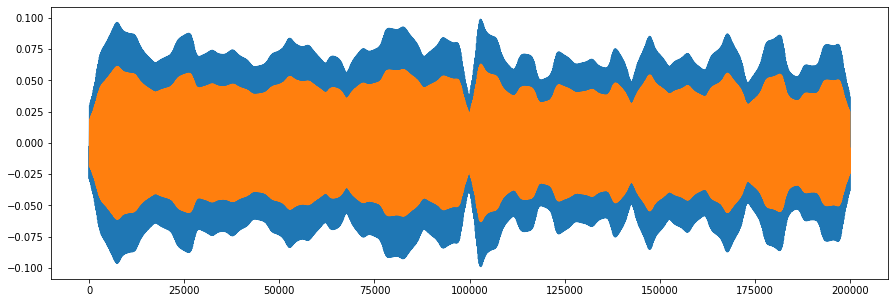

In [13]:
fig = plt.figure(figsize=(15,5))
plt.plot((df_test["signal_original"] - df_test["signal"]).values )
plt.plot((df_test["signal_original"] - df_test["signal"]).rolling(100).mean())

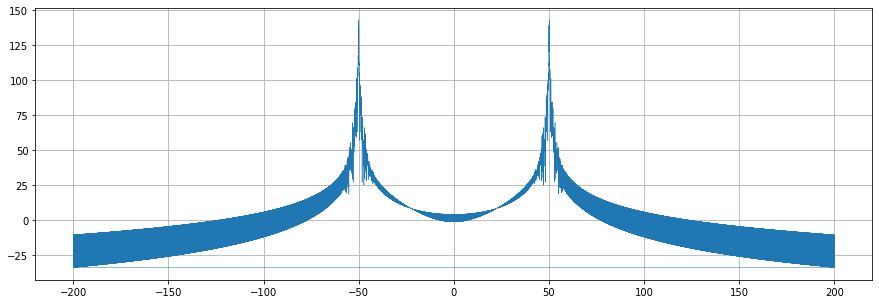

In [14]:
fig = plt.figure(figsize=(15,5))

fs=10000
fft = np.fft.fft((df_test["signal_original"] - df_test["signal"]).values)
psd = np.abs(fft) ** 2
fftfreq = np.fft.fftfreq(len(psd),1/fs)

i = abs(fftfreq) < 200
plt.grid()
plt.plot(fftfreq[i], 20*np.log10(psd[i]), linewidth=.5)

plt.show()

In [15]:
# # save train/test oof and prediction
# np.save('hmm_oof/train_oof_model4.npy', df_train["oof"])
# np.save('hmm_oof/test_oof_model4.npy', df_test["oof"])
# # np.save('hmm_pred/test_pred_model4.npy', df_test[TARGET])

In [16]:
# stop

In [17]:
print(use_cols)

['signal', 'viterbi_0', 'viterbi_1', 'viterbi_2', 'viterbi_3', 'viterbi_4', 'viterbi_5']


In [18]:
# cut the signal into sequences
SEQ_LEN = 400
def chop_seq(df_batch_i, is_train):

    df_batch_i_features = []
    df_batch_i_y = []
    df_batch_i_group = []
    
    WHOLE_LEN = 5e5 if is_train else 1e5
    
    for i in range(int(WHOLE_LEN/SEQ_LEN)):

        # (SEQ_LEN, 5)
        tmp = df_batch_i[(SEQ_LEN * i):(SEQ_LEN * (i + 1))]
        df_batch_i_features.append(tmp[use_cols].values)
        df_batch_i_y.append(tmp[TARGET].values)
        df_batch_i_group.append(tmp["group"].values)

    return df_batch_i_features, df_batch_i_y, df_batch_i_group

In [19]:
# TRAIN
df_train_seq = []
df_train_y = []
groups = []

for batch_i in BATCH_GROUP:
    df_batch_i = df_train[df_train.batch == batch_i]
    df_batch_i_features, df_batch_i_y, df_batch_i_group = chop_seq(df_batch_i, is_train=1)
    df_train_seq.append(df_batch_i_features)
    df_train_y.append(df_batch_i_y)
    groups.append(df_batch_i_group)

df_train_seq = np.array(df_train_seq).reshape(
    [-1, SEQ_LEN, np.array(df_train_seq).shape[-1]])
df_train_y = np.array(df_train_y).reshape([-1, SEQ_LEN])
groups = np.array(groups).reshape([-1, SEQ_LEN])[:,0]

print("TRAIN:", df_train_seq.shape, df_train_y.shape)

TRAIN: (2500, 400, 7) (2500, 400)


In [20]:
# TEST
df_test_seq = []
df_test_y = []
df_test_groups = []

mini_batch_list = [[1,3], [2,2]]
for batch_i, mini_batch_i in mini_batch_list:
    df_batch_i = df_test[(df_test.batch == batch_i) & (df_test.mini_batch == mini_batch_i)]
    df_batch_i_features, df_batch_i_y, df_test_batch_i_group = chop_seq(df_batch_i, is_train=0)
    df_test_seq.append(df_batch_i_features)
    df_test_y.append(df_batch_i_y)
    df_test_groups.append(df_test_batch_i_group)

df_test_seq = np.array(df_test_seq).reshape(
    [-1, SEQ_LEN, np.array(df_test_seq).shape[-1]])
df_test_y = np.array(df_test_y).reshape([-1, SEQ_LEN])
df_test_groups = np.array(df_test_groups).reshape([-1, SEQ_LEN])[:,0]

print("TEST:", df_test_seq.shape, df_test_y.shape)

TEST: (500, 400, 7) (500, 400)


In [21]:
def Classifier(shape_):
    
    def cbr(x, out_layer, kernel, stride, dilation):
        x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape = (shape_))
    x = cbr(inp, 64, 5, 1, 1)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = wave_block(x, 64, 3, 4)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = wave_block(x, 128, 3, 1)
    x = cbr(x, 32, 5, 1, 1)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    out = Dense(class_num, activation = 'softmax', name = 'out')(x)
    
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss = losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model

In [22]:
K.clear_session()
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
tf.compat.v1.keras.backend.set_session(sess)
oof_ = np.zeros([df_train_seq.shape[0], df_train_seq.shape[1], class_num])
preds_ = np.zeros((df_test_seq.shape[0] * df_test_seq.shape[1], class_num))

In [23]:
df_train_y = pd.get_dummies(df_train_y.reshape([-1])).values.reshape([-1, SEQ_LEN, class_num])
df_test_y = np.zeros([df_train_y.shape[0], df_train_y.shape[1], class_num])

In [24]:
gkf = GroupKFold(n_splits=5)

for index, (tr_idx, val_idx) in enumerate(gkf.split(df_train_seq, df_train_y, groups)):
    train_x, train_y = df_train_seq[tr_idx], df_train_y[tr_idx]
    valid_x, valid_y = df_train_seq[val_idx], df_train_y[val_idx]
    print("Running folder", index + 1, ": Evaluate on", np.unique(groups[val_idx]))
    print(f'Our training dataset shape is {train_x.shape}')
    print(f'Our validation dataset shape is {valid_x.shape}')
    
    shape_ = (None, train_x.shape[2])
    model = Classifier(shape_)
    cb_lr_schedule = LearningRateScheduler(lr_schedule)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    checkpoint_filepath = 'best_model.h5'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    model.fit(train_x,train_y,
              epochs = nn_epochs,
              callbacks = [cb_lr_schedule, early_stop, model_checkpoint_callback], 
              batch_size = nn_batch_size, verbose = 0,
              validation_data = (valid_x,valid_y))
    model.load_weights(checkpoint_filepath)

    preds_f = model.predict(valid_x)
    f1_score_ = f1_score(np.argmax(valid_y, axis=2).reshape(-1),  np.argmax(preds_f, axis=2).reshape(-1), average = 'macro') 
    print(f'Training fold {index + 1} completed. macro f1 score : {f1_score_ :1.5f}')
    oof_[val_idx] += preds_f
    te_preds = model.predict(df_test_seq)
    te_preds = te_preds.reshape(-1, te_preds.shape[-1])           
    preds_ += te_preds / gkf.n_splits

Running folder 1 : Evaluate on ['6_5' '9_5']
Our training dataset shape is (2000, 400, 7)
Our validation dataset shape is (500, 400, 7)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Epoch 00036: early stopping
Training fold 1 completed. macro f1 score : 0.97425
Running folder 2 : Evaluate on ['6_4' '9_4']
Our training dataset shape is (2000, 400, 7)
Our validation dataset shape is (500, 400, 7)
Epoch 00036: early stopping
Training fold 2 completed. macro f1 score : 0.97257
Running folder 3 : Evaluate on ['6_3' '9_3']
Our training dataset shape is (2000, 400, 7)
Our validation dataset shape is (500, 400, 7)
Epoch 00022: early stopping
Training fold 3 completed. macro f1 score : 0.97496
Running folder 4 : Evaluate on ['6_2' '9_2']
Our training dataset shape is (2000, 400, 7)
Our validation dataset shape is (500, 400, 7)
Epoch 00034: early stopping
Training fold 4 completed. macro f1 score : 0.97348
Running folder 5 : Evaluate on ['6_1' '9_1']
Our traini

In [25]:
# NN oof F1 score is 0.97386
print("NN oof F1 score is", f1_score(df_train_y.reshape([-1,class_num]).argmax(axis=1), oof_.reshape([-1,class_num]).argmax(axis=1), average = 'macro').round(5))

NN oof F1 score is 0.97417


In [26]:
oof_pred = oof_.reshape([-1,class_num]).argmax(axis=1)
df_train["nn_oof"] = oof_pred

test_pred = preds_.argmax(axis=1)
df_test.loc[df_test.group.isin(TEST_GROUP), TARGET] = test_pred
print(f"oof shape is {oof_pred.shape}, test pred shape is {test_pred.shape}")

oof shape is (1000000,), test pred shape is (200000,)


In [27]:
# save oof and prediction
np.save('hmm_oof/train_nn_oof_model4.npy', oof_pred)
np.save('hmm_pred/test_nn_oof_model4.npy', df_test[TARGET].values)

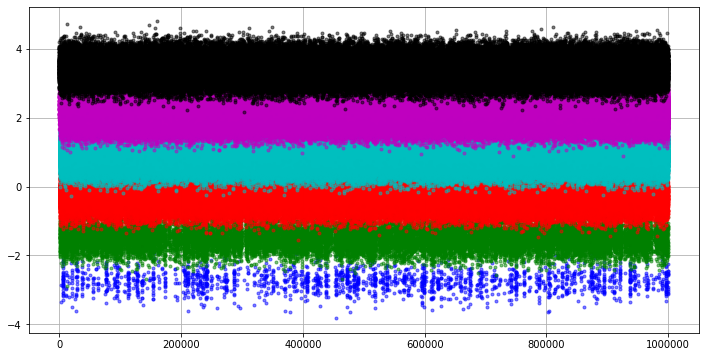

In [28]:
# train target plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_train[df_train.open_channels == channel_i].signal_original,
             ".",
             color=color_list[channel_i],
             alpha=0.5)

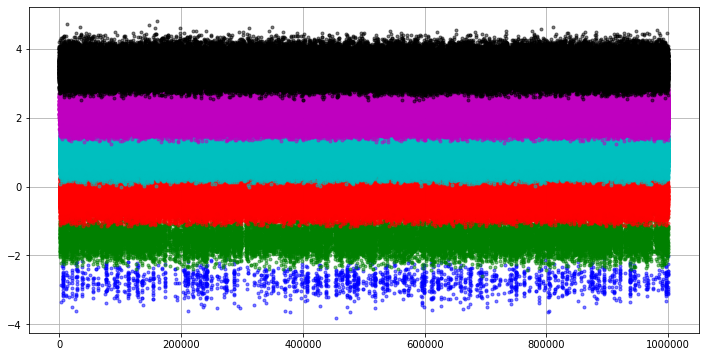

In [29]:
# train oof plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_train[df_train.nn_oof == channel_i].signal_original,
             ".",
             color=color_list[channel_i],
             alpha=0.5)

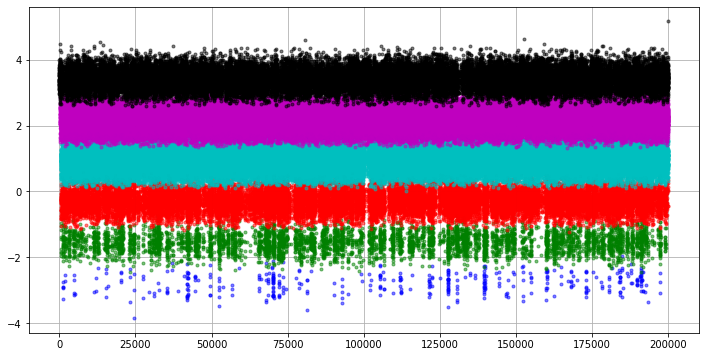

In [30]:
# test oof plot - hmm prediction
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_test[(df_test.oof == channel_i)  & (df_test.group.isin(TEST_GROUP))].signal_original,
             ".",
             color=color_list[channel_i],
             alpha=0.5)
# plt.xlim([0,50000])

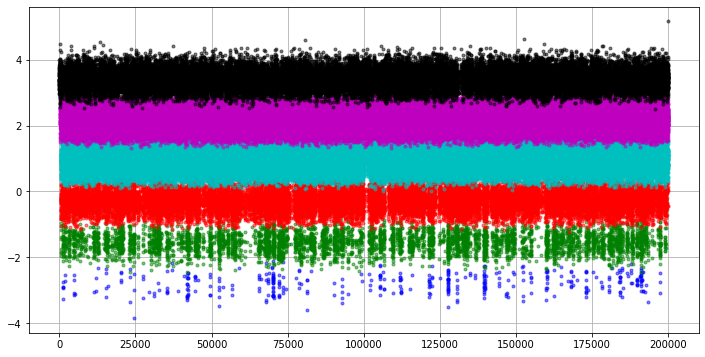

In [31]:
# test predict plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_test[(df_test.open_channels == channel_i)  & (df_test.group.isin(TEST_GROUP))].signal_original,
             ".",
             color=color_list[channel_i],
             alpha=0.5)
# plt.xlim([0,50000])